Read clustering results (xlsx files, output from `mc_analysis_cluster.py`). Plot clustering accuracy.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statannotations.Annotator import Annotator
plt.style.use('figure.mplstyle')

In [7]:
excelfile = r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Cluster ybin20 ysigma0.xlsx'
exps = ['Enriched','Dissimilar','Similar']
colors = ['tab:red','tab:blue','tab:green']

A = pd.read_excel(excelfile, sheet_name='Cluster')
print(A)

    Fraction     Context
0   0.866667    Enriched
1   0.516667    Enriched
2   1.000000    Enriched
3   0.975000    Enriched
4   0.833333  Dissimilar
5   0.883333  Dissimilar
6   0.983333  Dissimilar
7   0.600000     Similar
8   0.550000     Similar
9   0.675000     Similar
10  0.525000     Similar
11  0.631579     Similar
12  0.575000     Similar
13  0.589744     Similar
14  0.550000     Similar


In [8]:
for p, exp in enumerate(exps):    
    print('-'*16 + f' {exp} ' + '-'*16)
    data = A['Fraction'][A['Context']==exp]
    pval = stats.shapiro(data)[1]
    if pval >= 0.05:
        print(f'Shapiro test p={pval:.4f}, likely normal distribution')
    else:
        print(f'Shapiro test p={pval:.4f}, unlikely normal distribution')
    pval = stats.ttest_1samp(data, 0.5, alternative='greater')[1]
    print(f't-test for fraction not greater than 0.5: p={pval:.4f}')

---------------- Enriched ----------------
Shapiro test p=0.1494, likely normal distribution
t-test for fraction not greater than 0.5: p=0.0278
---------------- Dissimilar ----------------
Shapiro test p=0.6369, likely normal distribution
t-test for fraction not greater than 0.5: p=0.0060
---------------- Similar ----------------
Shapiro test p=0.7785, likely normal distribution
t-test for fraction not greater than 0.5: p=0.0007


t-test for accuracy not greater than 0.5: p=0.0278
t-test for accuracy not greater than 0.5: p=0.0060
t-test for accuracy not greater than 0.5: p=0.0007
----------------
One-way ANOVA test: p=0.0028
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Enriched vs. Dissimilar: Custom statistical test, P_val:7.955e-01
Dissimilar vs. Similar: Custom statistical test, P_val:6.581e-03
Enriched vs. Similar: Custom statistical test, P_val:1.371e-02


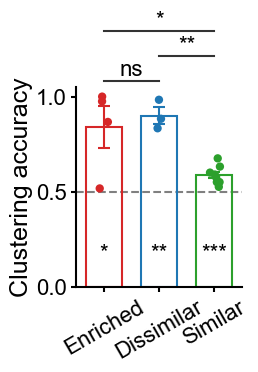

In [11]:
def plot_summary(excelfile, exps=['Enriched','Dissimilar','Similar'],
                 colors=['tab:red','tab:blue','tab:green']):

    fsize = plt.rcParams['font.size']
    lwidth = plt.rcParams['axes.linewidth']
    
    A = pd.read_excel(excelfile, sheet_name='Cluster')
    accuracy = [A['Fraction'][A['Context']==exp] for exp in exps]

    width = 0.65  # Bar width
    ypos = 0.15  # y position to place the statistical annotations
    fig, ax = plt.subplots(figsize=(2.8,4.4))
    ax.axhline(0.5, ls='--', c='gray', zorder=-1)

    for p, exp in enumerate(exps):
        height = np.mean(accuracy[p])
        yerr = stats.sem(accuracy[p])
        ax.bar(p, height, yerr=yerr, width=width, color='none', linewidth=lwidth, 
               edgecolor=colors[p], ecolor=colors[p], capsize=4,
               error_kw=dict(elinewidth=lwidth, capthick=lwidth))
        pval = stats.ttest_1samp(accuracy[p], 0.5, alternative='greater')[1]
        print(f't-test for accuracy not greater than 0.5: p={pval:.4f}')
        if pval < 0.001:
            ax.text(p, ypos, '***', ha='center')
        elif pval < 0.01:
            ax.text(p, ypos, '**', ha='center')
        elif pval < 0.05:
            ax.text(p, ypos, '*', ha='center')
        else:
            ax.text(p, ypos, 'ns', ha='center')
    
    sns.stripplot(data=A, x='Context', y='Fraction', hue='Context', palette=colors, ax=ax, size=6, jitter=0.1)
    
    ## Multiple comparison
    print('-'*16)
    print('One-way ANOVA test: p=%.4f' % stats.f_oneway(*accuracy)[1])
    pairs, pvalues = [], []
    post_hocs = stats.tukey_hsd(*accuracy)
    for u, v in zip([0,0,1],[1,2,2]):
        pairs.append([exps[u], exps[v]])
        pvalues.append(post_hocs.pvalue[u,v])
    
    pformat = {'pvalue_thresholds':[[1e-3,'***'],[1e-2,'**'],[0.05,'*'],[1,'ns']], 'fontsize':fsize}
    annot = Annotator(ax, pairs, data=A, x='Context', y='Fraction')
    annot.configure(test=None, loc='outside', line_width=lwidth, line_height=0., pvalue_format=pformat)
    annot.set_pvalues(pvalues)
    annot.annotate()
    
    return fig, ax

fig, ax = plot_summary(excelfile, exps=exps, colors=colors)
ax.set(ylabel='Clustering accuracy', xlabel='', xticks=range(len(exps)))
ax.set_xticklabels(exps, rotation=30)
ax.get_legend().remove()
fig.tight_layout()
# fig.savefig('Cluster accuracy.svg')